## Project Description 
The dataset presents pet's characteristics and includes tabular, text and image data. It's come from: https://www.petfinder.my.

The aim is to predict the rate at which a pet is adopted.

Data fields:

- index - Unique hash ID of pet profile
- Type - Dog or Cat
- Age - Age of pet when listed, in months
- Gender - Gender of pet (Male, Female, Mixed, if profile represents group of pets)
- Color1 - Color 1 of pet
- Color2 - Color 2 of pet 
- Color3 - Color 3 of pet 
- MaturitySize - Size at maturity (Small, Medium, Large, Extra Large, Not Specified)
- FurLength - Fur length (Short, Medium, Long, Not Specified)
- Vaccinated - Pet has been vaccinated (Yes, No, Not Sure)
- Dewormed - Pet has been dewormed (Yes, No, Not Sure)
- Sterilized - Pet has been spayed / neutered (Yes, No, Not Sure)
- Health - Health Condition (Healthy, Minor Injury, Serious Injury, Not Specified)
- Fee - Adoption fee (0 = Free)
- Breed - breed of pet (see on the dataset)
- Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.
- Image - a pointer to an image


The aim is to predic AdoptionSpeed. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way: 
- 0 - Pet was adopted on the same day as it was listed. 
- 1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 
- 2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 
- 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
- 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

# Importing Libraries

In [1]:
# Libraries for data manipulation and visualization
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

#Libraries for image processing and feature extraction
import cv2
from skimage import io

#Libraries for machine learning models and evaluation metrics
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

#Libraries for word cloud visualization
from wordcloud import WordCloud

#Libraries for progress bar
from tqdm import tqdm

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Loading the train and test dataframes:

In [3]:
#Load the train and test dataframes:
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv') 

In [4]:
train.columns #Checking the columns in our train dataframe

Index(['Type', 'Age', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Fee',
       'Description', 'AdoptionSpeed', 'Images', 'Breed'],
      dtype='object')

Creating our X_train and y_train, X_train containing all of the columns and the y_train containig our target column which is the "AdoptionSpeed" column : 

In [5]:
X_train = train.drop(['AdoptionSpeed'], axis=1)
y_train = train.AdoptionSpeed

Splittig the columns into 2 categories :
- Numerical Features : which will represent the column containing numerical features (in this case Age and Fee)
- Categorical Features : which will represent the columns containing categorical features (limited values that we will convert to numerical using Hot Encoding in order to use them in the training because we can't use actual words in training our model)

In [6]:
numerical_features = ['Age', 'Fee']
categorical_features = ['Type', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Breed']

Loading the images into our the "Images" column in both the train and test dataframes : 

In [7]:
img_dir = "all_train_pics\\" 
X_train['Images'] = [img_dir+img for img in train['Images']]

In [8]:
img_dir = "test_images\\"
test['Images'] = [img_dir+img for img in test['Images']]

# Understanding the Data : 

### Distribution of AdoptionSpeed: 

Plotting a histogram or a bar chart of the AdoptionSpeed column to understand the distribution of pets' adoption rate, which will give an idea of the frequency of different categories of the target variable.

<Axes: xlabel='AdoptionSpeed', ylabel='Count'>

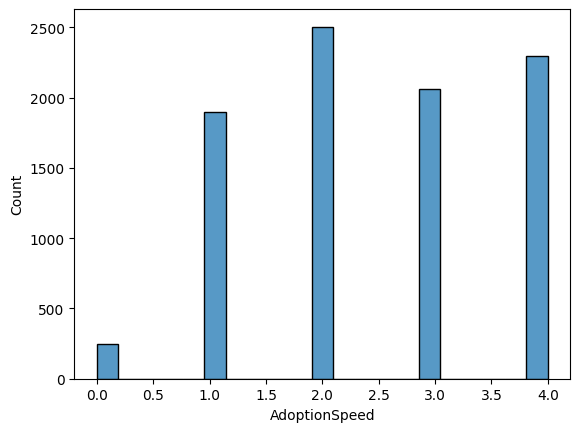

In [9]:
import seaborn as sns

sns.histplot(data=train, x="AdoptionSpeed", kde=False)

### Pet types that are the most strayed:

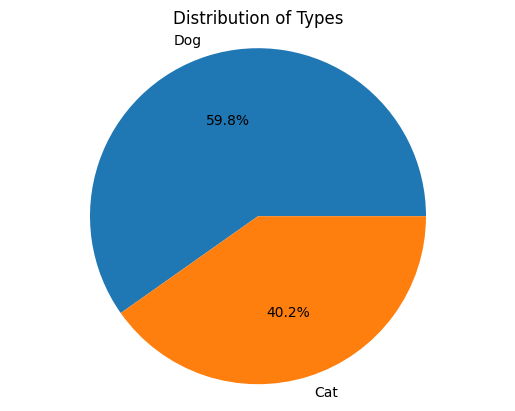

In [73]:
# Count of each unique value in 'Type' column
type_counts = X_train['Type'].value_counts()

# Plot a pie chart
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of Types')
plt.show()

### Adoption speed counts by type:

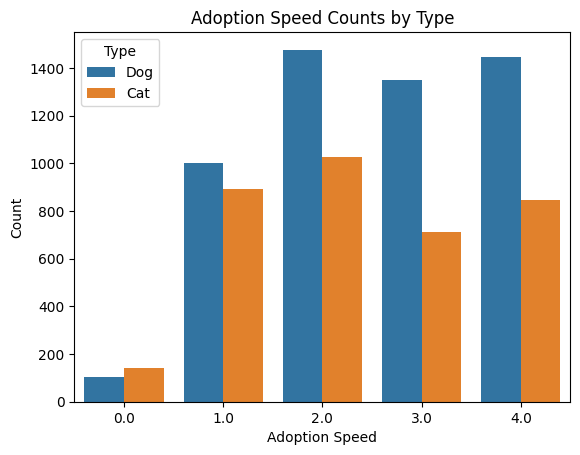

In [75]:
import seaborn as sns

sns.countplot(x='AdoptionSpeed', hue='Type', data=train)
plt.title('Adoption Speed Counts by Type')
plt.xlabel('Adoption Speed')
plt.ylabel('Count')
plt.show()

### Correlation matrix: 

Plotting a correlation matrix between numerical features (Age, Fee) and the target variable (AdoptionSpeed) will help identify whether there is any correlation between these features and the target variable.

<Axes: >

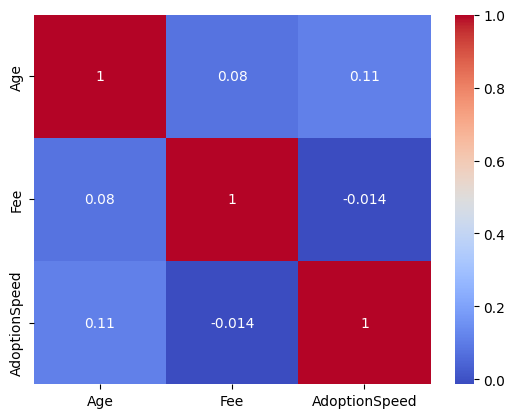

In [10]:
corr = train[['Age', 'Fee', 'AdoptionSpeed']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")

based on this correlation matrix, we can conclude that there is no strong correlation between any of the variables, but some weak correlations do exist. 

### Word cloud: 

Creating a word cloud for the Description column to visualize the most common words used in pet profiles, which can give insights into the most frequently mentioned characteristics of pets.

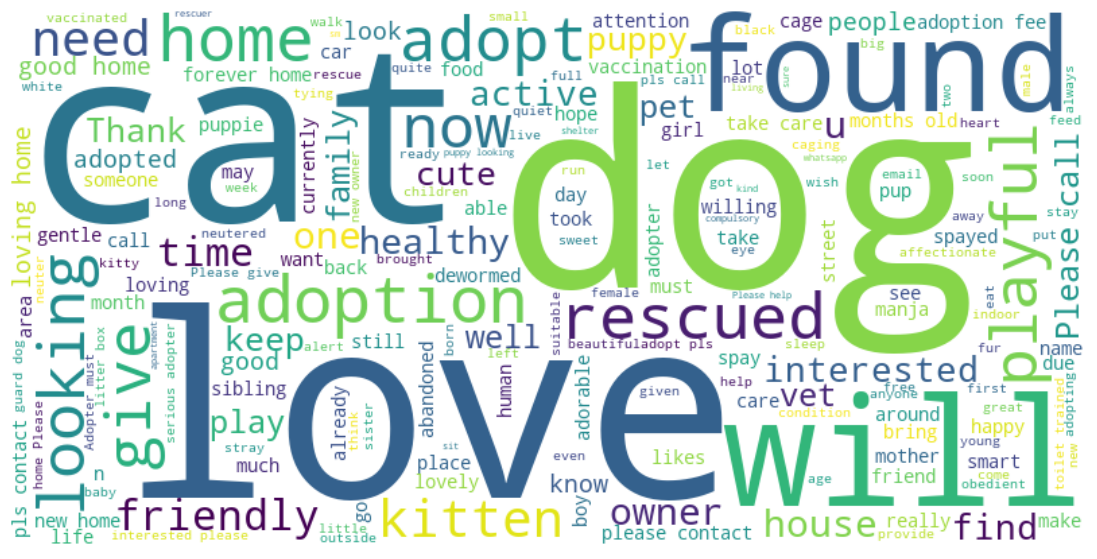

In [11]:
text = ' '.join(train['Description'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Image visualization: 

Since the dataset includes image data, it can be useful to visualize some of the images to get an idea of the different pet breeds, colors, and sizes in the dataset. This can also help identify any potential issues with image quality or labeling.

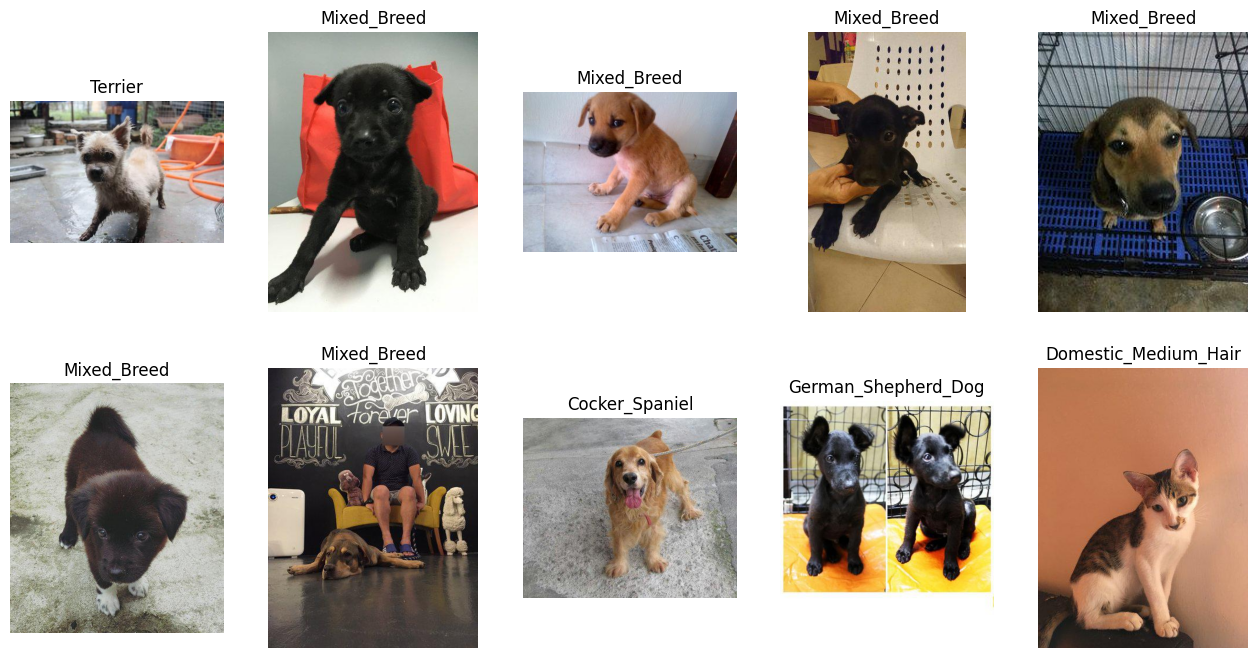

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(16, 8))
axs = axs.ravel()

for i in range(10):
    img_path = X_train.loc[i, 'Images']
    if not os.path.exists(img_path):
        print("Image file not found: ", img_path)
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(train.loc[i, 'Breed'])

plt.show()


# Describing & Cleaning the Data : 

In [13]:
# Number of observations for the train and test data
print("Number of observations in train set:", len(X_train))
print("Number of observations in test set:", len(test))

Number of observations in train set: 9000
Number of observations in test set: 500


In [14]:
# Types of each feature
print("Data types of features:")
print(X_train.dtypes)

Data types of features:
Type             object
Age             float64
Gender           object
Color1           object
Color2           object
Color3           object
MaturitySize     object
FurLength        object
Vaccinated       object
Dewormed         object
Sterilized       object
Health           object
Fee             float64
Description      object
Images           object
Breed            object
dtype: object


In [15]:
# Number of observations per class
print("Number of observations per class:")
print(train['AdoptionSpeed'].value_counts())

Number of observations per class:
2.0    2504
4.0    2294
3.0    2061
1.0    1894
0.0     247
Name: AdoptionSpeed, dtype: int64


In [16]:
# Determine if the dataset is balanced or not
class_counts = train['AdoptionSpeed'].value_counts()
print("Is the dataset balanced? ", all(class_counts == class_counts.iloc[0]))

Is the dataset balanced?  False


The dataset is not balanced so we'll need to balance it, and to do that I'll be implementing one of the methods seen in class which is the **SMOTE** because  it generates synthetic samples for the minority class by interpolating between existing samples which helps balance the number of samples in each class and improves the performance of the model by reducing the bias towards the majority class.

In [18]:
#Removing duplicates:
X_train.drop_duplicates(inplace=True)

In [19]:
#Handling missing values:
# drop rows with missing values
X_train.dropna(inplace=True)

In [20]:
# convert all values in a column to lowercase
X_train['Description'] = X_train['Description'].str.lower()

# Building our Pipeline 

Building the sklearn transformer, which will be inserted into the pipeline allowing us to accept images and produce a BOF (Bag of Features) :

**Step 1** : extract the SIFTs of each image

The extract_SIFT function takes a list of image file paths and returns the total number of SIFT descriptors and a list of the SIFT descriptors for each image. The tqdm function is used to display a progress bar during the extraction process.

In [22]:
# Step 1 : extract the SIFTs of each image
def extract_SIFT(img_lst):
    nbSIFTs = 0    # Nomber of SIFTs
    SIFTs = []  # List of SIFTs qdescriptors 
    #dimImgs = []   # Nb of descriptors associated to each images

    for pathImg in tqdm(img_lst, position=0, leave=True): 
        img = io.imread(pathImg)
        if len(img.shape)==2: # this is a grey level image
            gray = img
        else: # we expect the image to be a RGB image or RGBA
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(gray, None)
        if len(kp) == 0 and img.shape[2]==4:
            gray = img[:,:,3]
            sift = cv2.SIFT_create()
            kp, des = sift.detectAndCompute(gray, None)
        
        nbSIFTs += des.shape[0]
        SIFTs.append(des)
    return nbSIFTs, SIFTs#, dimImgs

**Step 2** : extract SIFTs from a list of image and return it

The clusterize function takes the list of SIFT descriptors and a hyperparameter nb_img_features, which determines the number of clusters to use in the MiniBatchKMeans clustering algorithm. The function returns the trained clusterizer object.

In [23]:
# Step 2: clusterize the SIFT
from sklearn.cluster import MiniBatchKMeans

def clusterize(SIFTs, nb_img_features=5, verbose=False):
    clusterizer = MiniBatchKMeans(n_clusters=nb_img_features)
    # learning of the clustering
    flat_list = SIFTs[0]
    for des in SIFTs[1:]:
        flat_list = np.concatenate((flat_list, des))
        if verbose:
            print("shape:", des.shape, flat_list.shape)
    clusterizer.fit(flat_list)
    # we now know the label of each SIFT descriptor
    return clusterizer

**Step 3** : build the BOW representation of each images 

The build_BOFs function takes the list of SIFT descriptors and the trained clusterizer object and returns a numpy array of BOF representations for each image. It first builds a flat list of all the SIFT descriptors from all images and predicts the cluster labels for each descriptor using the predict method of the clusterizer. It then counts the number of descriptors that belong to each cluster for each image and appends this to the BOFs array.

In [24]:
# Step 3: build the BOW representation of each images (i.e. construction of the BOFs)

def build_BOFs(SIFTs, clusterizer, verbose=False):
    ok, nok = 0, 0
    #BOF initialization
    nb_img_features = clusterizer.get_params()['n_clusters']
    BOFs = np.empty(shape=(0, nb_img_features), dtype=int)

    # Build label list
    flat_list = SIFTs[0]
    for des in SIFTs[1:]:
        flat_list = np.concatenate((flat_list, des))
        if verbose:
            print("shape:", des.shape, flat_list.shape)
    labels = clusterizer.predict(flat_list)

    # loop on images
    i = 0 # index for the loop on SIFTs
    for des in SIFTs:
        #initialisation of the bof for the current image
        tmpBof = np.array([0]*nb_img_features)
        j = 0
        # for every SIFT of the current image:
        nbs = des.shape[0]
        while j < nbs:
            tmpBof[labels[i]] += 1
            j+=1
            i+=1
        BOFs = np.concatenate((BOFs, tmpBof.reshape(1,-1)), axis=0)
    if verbose:
        print("BOFs : ", BOFs)
    
    return BOFs

**Step 4** : Build transformer for image

In [25]:
from sklearn.base import BaseEstimator,TransformerMixin

class image_process(BaseEstimator,TransformerMixin):    
    def __init__(self, nb_img_features=10, verbose=False):
        self.nb_img_features = nb_img_features
        self.verbose = verbose
        if self.verbose:
            print("BOF.init()")
        
    def fit(self, X, y=None):
        if self.verbose:
            print("BOF.fit()")
        nbSIFTs, SIFTs = extract_SIFT(X)
        self.clusterizer = clusterize(SIFTs, self.nb_img_features, self.verbose)
        
    def transform(self, X, y=None):
        if self.verbose:
            print("BOF.transform()")
        nbSIFTs, SIFTs = extract_SIFT(X)
        if self.verbose:
            print("nbSIFTs:", nbSIFTs)
        return build_BOFs(SIFTs, self.clusterizer, self.verbose)
    
    def fit_transform(self, X, y=None):
        if self.verbose:
            print("BOF.fit_transform()")
        nbSIFTs, SIFTs = extract_SIFT(X)
        self.clusterizer = clusterize(SIFTs, self.nb_img_features, self.verbose)
        return build_BOFs(SIFTs, self.clusterizer, self.verbose)

Creating our preprocessors : 
- **Numerical Preprocessor** : This preprocessor is an instance of StandardScaler used to standardize numerical variables (scale them to have zero mean and unit variance)


- **Categorical Preprocessor** : This preprocessor is an instance of OneHotEncoder used to transform categorical variables into numerical ones by creating binary columns for each unique category. 


- **Text Preprocessor** : This preprocessor is an instance of CountVectorizer used to transform text data into a matrix of token counts. It creates a vocabulary of words and assigns a count to each word in the vocabulary based on how many times it appears in the text.


- **Image Preprocessor** : This preprocessor is the custom transformer "image_process" that we created earlier which used for processing image data. Given the nb_cluster=4 it uses K-means clustering to extract features from images. 

In [26]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore") #handle_unknown="ignore" parameter is used to ignore unknown categories that were not seen during fitting.
numerical_preprocessor = StandardScaler()
text_preprocessor = CountVectorizer()
image_preprocessor = image_process(nb_img_features=3, verbose=False)

Using ColumnTransformer we assemble all the previous preprocessors into one in order to use them in our pipeline, except for now we're not going to include the image preprocessor because we have 9500 images and including them in the gridsearch is impossible for the computer to process (it either crashes because the memory is being overused or it takes at least 5 days to make 30 iterations then crash) then **once we have the best parameters** to use we are going to recall the preprocessor including the images because once we have the best parameters we'll only have to fit our model once (unlike with gridsearch where all the images are used over and over to find the best parameters which is computationally not possible in this case)

In [27]:
preprocessor = ColumnTransformer([
    ("categorical encoding", categorical_preprocessor, categorical_features),
    ("numerical encoding", numerical_preprocessor, numerical_features),
    ("text encoding", text_preprocessor, 'Description')
    #("image encoding", image_preprocessor, 'Images'),
])

### 1st pipeline : using Support Vector Machine Classifier (SVM)
I chose SVM because It is a powerful classifier that can handle both linear and non-linear data. It is useful when dealing with high-dimensional data and can work with both tabular and image data.

First I started by creating a sampler in which I used SMOTE in order to balance the dataset as I stated earlier, then I created a pipeline (from the imblearn library because when I tried to use SMOTE with the sklearn pipeline I faced issues) which included the preprocessor which treats all the type of the data of the dataset then the sampler to balance the dataset and finally the model which in this first case is SVM.

Second I defined multiple parameters for the grid along with the scoring metric which in this case is the 'cohen kappa' as instructed in the project description, and finally I created a gridsearch in order to find the best parameters that provides us with the best score 

In [44]:
# Create an imblearn pipeline
sampler = SMOTE(sampling_strategy='auto', k_neighbors=5)
svm = SVC()
pipeline = make_pipeline(preprocessor,sampler,svm)

# Define the grid parameters
parameters = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['rbf', 'linear'],
    'svc__gamma': ['scale', 'auto']
}

# Define the scoring metric
scorer = make_scorer(cohen_kappa_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, parameters, scoring=scorer, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best score and best parameters
print("Best score: ", grid_search.best_score_)
print("Best parameters: ", grid_search.best_params_)

#By default, GridSearchCV sets cv=5, which means that it will use a 5-fold cross-validation procedure to evaluate the performance of each combination of hyperparameters. This means that the data will be split into 5 equally sized folds, and the model will be trained on 4 folds and tested on the remaining fold in each of the 5 iterations. The performance of the model will be computed as the average of the performance across the 5 folds.

Best score:  0.1994782389986646
Best parameters:  {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


In [46]:
cross_val_score(pipeline, X_train, y_train, cv=5, scoring=make_scorer(cohen_kappa_score))

array([0.17230696, 0.16655913, 0.19249267, 0.16346758, 0.17481344])

The array of scores shows the performance of the model on each of the 5 folds of the cross-validation process, the scores range between 0.16 and 0.19, which suggests that the model is not performing very well. A score of 0.17 indicates only slight agreement between predicted and true labels, while a score of 0.19 indicates moderate agreement.

### 2nd pipeline : using Logistic Regression
I chose Logistic Regression because  It is a widely used classifier for tabular data. It models the probability of an event occurrence by fitting data to a logistic function.

In [48]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampling', sampler),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

parameters = {
              'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'classifier__penalty': ['l1', 'l2', 'elasticnet'],
              'classifier__C': [100, 10, 1.0, 0.1, 0.01]
  }

grid_search_lr = GridSearchCV(pipe, parameters, scoring=scorer, cv=5)

grid_search_lr.fit(X_train, y_train)

print("Best score: ", grid_search_lr.best_score_)
print("Best parameters: ", grid_search_lr.best_params_)

Best score:  0.1879139307779278
Best parameters:  {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [50]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring=make_scorer(cohen_kappa_score))

array([0.19227233, 0.18425511, 0.17046255, 0.17605517, 0.1741517 ])

### 3rd pipeline : using K-Nearest Neighbors
I decided to use KNN because It is a non-parametric classifier that can be used for both tabular and image data.KNN can be used to classify the adoption speed of pets based on the similarity of their characteristics to those of already adopted pets.

In [51]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampling', sampler),
    ("classifier",KNeighborsClassifier())
])
parameters = {
              'classifier__n_neighbors': range(1, 21, 2),
              'classifier__weights': ['uniform', 'distance'],
              'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
  }

grid_search_knn = GridSearchCV(pipe, parameters, scoring=scorer, cv=5)
grid_search_knn.fit(X_train, y_train)

print("Best score: ", grid_search_knn.best_score_)
print("Best parameters: ", grid_search_knn.best_params_)

Best score:  0.1873934761854061
Best parameters:  {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 1, 'classifier__weights': 'uniform'}


In [52]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring=make_scorer(cohen_kappa_score))

array([0.10632649, 0.08821385, 0.12711921, 0.11298341, 0.07548824])

### 4th pipeline : using Bagging Decision Trees
I added Baggign Decision Trees classifier too because It is an ensemble learning technique that combines multiple decision trees to create a strong model. This technique is well suited for tabular data and can handle both linear and non-linear relationships between the features. It can also handle noisy data by reducing the variance in the model.

In [53]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampling', sampler),
    ("classifier",BaggingClassifier())
])
parameters = {
              'classifier__n_estimators': [10, 100, 1000]
  }


grid_search_bdt = GridSearchCV(pipe, parameters, scoring=scorer, cv=5)
grid_search_bdt.fit(X_train, y_train)

print("Best score: ", grid_search_bdt.best_score_)
print("Best parameters: ", grid_search_bdt.best_params_)

Best score:  0.2588638755216946
Best parameters:  {'classifier__n_estimators': 100}


In [54]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring=make_scorer(cohen_kappa_score))

array([0.20932302, 0.18405815, 0.23795722, 0.22300658, 0.21664431])

### 5th pipeline : using Random Forest Classifier
I chose Random Forest Classifier because It is an ensemble learning technique that uses a combination of decision trees. It is well suited for handling tabular data and has good performance in handling high-dimensional data.

In [55]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampling', sampler),
    ("classifier", RandomForestClassifier())
])
parameters = {
              'classifier__n_estimators': [10, 100, 1000],
              'classifier__max_features': ['sqrt', 'log2']
  }

grid_search_rfc = GridSearchCV(pipe, parameters, scoring=scorer, cv=5)
grid_search_rfc.fit(X_train, y_train)

print("Best score: ", grid_search_rfc.best_score_)
print("Best parameters: ", grid_search_rfc.best_params_)

Best score:  0.26334464967189863
Best parameters:  {'classifier__max_features': 'sqrt', 'classifier__n_estimators': 1000}


In [56]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring=make_scorer(cohen_kappa_score))

array([0.23792957, 0.23126043, 0.24398315, 0.22547682, 0.25034966])

### 6th pipeline : using Gradient Boosting Classifier
I decided to add Gradient Boosting Classifier because It is another ensemble learning technique that combines multiple weak models to create a strong model. It has high accuracy and is suitable for handling tabular data.

In [57]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampling', sampler),
    ("classifier",GradientBoostingClassifier())
])

parameters = {
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [2, 3, 4]
}


grid_search_GB = GridSearchCV(pipe, parameters, scoring=scorer, cv=5)
grid_search_GB.fit(X_train, y_train)

print("Best score: ", grid_search_GB.best_score_)
print("Best parameters: ", grid_search_GB.best_params_)


Best score:  0.21910671096990536
Best parameters:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 200}


In [58]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring=make_scorer(cohen_kappa_score))

array([0.17788151, 0.18592048, 0.21066084, 0.19574804, 0.19255994])

### 7th pipeline : using XG Boost Classifier
I decided to add XG Boost Classifier because It is particularly effective for solving classification and regression problems with large and complex datasets

In [60]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampling', sampler),
    ("classifier",XGBClassifier())
])

parameters = {
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': [3, 5],
    'classifier__n_estimators': [100, 200]
}


grid_search_XGB = GridSearchCV(pipe, parameters, scoring=scorer, cv=5)
grid_search_XGB.fit(X_train, y_train)

print("Best score: ", grid_search_XGB.best_score_)
print("Best parameters: ", grid_search_XGB.best_params_)

Best score:  0.20509334245464172
Best parameters:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}


In [61]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring=make_scorer(cohen_kappa_score))

array([0.21968506, 0.21659515, 0.24402571, 0.2133301 , 0.22997263])

Best Score Obtained for each classifier before applying SMOTE : 
- SVM : 0.18876110578305788
- Logistic Regression : 0.1835110099388536
- KNN : 0.14854119005872135
- Bagging Decision Trees : 0.2364663114093602
- Random Forest : 0.23268113808547708
- Gradient Boosting : 0.203281666805746
- XGB : 0.20218221315904633


Best Score Obtained for each classifier after applying SMOTE : 
- SVM : 0.1994782389986646
- Logistic Regression : 0.1879139307779278
- KNN :  0.1873934761854061
- Bagging Decision Trees : 0.2588638755216946
- Random Forest : 0.26334464967189863
- Gradient Boosting : 0.21910671096990536
- XGB : 0.20509334245464172

**Note :** After adding the scoring metric as "cohen_kappa_score" in the gridsearch, all scores dropped down by 50% but it didn't effect the predictions nor did it effect the best parameters (the best parameters were the same before and after making cohen_kappa_score as the scoring metric for the gridsearch, besides for KNN where the metric, n_neighbors and weights changed when we switched to cohen_kappa_score). 

That's because this metric measures the agreement between predicted and true labels, while taking into account the chance agreement between the two. This is a more stringent evaluation metric than accuracy since it takes into account the agreement that would be expected by chance.

# Evaluating each model :

In this part, I'll be using the best parameters that I got from the GridSearch in order to fit the model but this time the preprocessor will include the images too:

In [62]:
#redifining the preprocessor but this time we'll take in consideration the images too
preprocessor = ColumnTransformer([
    ("categorical encoding", categorical_preprocessor, categorical_features),
    ("numerical encoding", numerical_preprocessor, numerical_features),
    ("text encoding", text_preprocessor, 'Description'),
    ("image encoding", image_preprocessor, 'Images')
])

### SVC Model Predictions :

In [63]:
#Using the best parameters generated by the gridSearch
svc = SVC(C = 10, gamma = 'scale', kernel = 'rbf')

#creating our pipeline with the preprocessor and classifier
model_svc = make_pipeline(preprocessor,sampler, svc) 

#fitting the data
model_svc.fit(X_train,y_train) 

#predicting on the test dataset
ypred_SVC = model_svc.predict(test) 

#saving the prediction in a dataframe to be combined with the others at the end of this notebook 
df_results = pd.DataFrame({"SVC": ypred_SVC}) 
df_results.head()

100%|██████████| 500/500 [00:19<00:00, 25.33it/s]


,SVC
0,0.0
1,0.0
2,1.0
3,1.0
4,1.0


### Logistic Regression Model Predictions :

In [65]:
lr = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'lbfgs')

model_lr = make_pipeline(preprocessor,sampler, lr)
model_lr.fit(X_train,y_train)

ypred_LR = model_lr.predict(test)

df_results2 = pd.DataFrame({"LR": ypred_LR})
df_results2.head()

100%|██████████| 500/500 [00:17<00:00, 27.83it/s]


,LR
0,1.0
1,2.0
2,3.0
3,3.0
4,1.0


### K-Nearest Neighbors Model Predictions :

In [66]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors = 1, weights = 'uniform')

model_knn = make_pipeline(preprocessor,sampler, knn)
model_knn.fit(X_train,y_train)

ypred_KNN = model_knn.predict(test)

df_results3 = pd.DataFrame({"KNN": ypred_KNN})

df_results3.head()

100%|██████████| 500/500 [00:24<00:00, 20.01it/s]


,KNN
0,4.0
1,3.0
2,4.0
3,3.0
4,4.0


### Bagging Classifier Model Predictions :

In [68]:
bc = BaggingClassifier(n_estimators = 100)

model_bc = make_pipeline(preprocessor,sampler, bc)
model_bc.fit(X_train,y_train)

ypred_BC = model_bc.predict(test)

df_results4 = pd.DataFrame({"BC": ypred_BC})

df_results4.head()

100%|██████████| 500/500 [00:17<00:00, 28.93it/s]


,BC
0,1.0
1,4.0
2,2.0
3,2.0
4,2.0


### Random Forest Classifier Model Predictions :

In [69]:
rf = RandomForestClassifier(max_features = 'sqrt', n_estimators = 1000)

model_rf = make_pipeline(preprocessor,sampler, rf)
model_rf.fit(X_train,y_train)

ypred_RF = model_rf.predict(test)

df_results5 = pd.DataFrame({"RF": ypred_RF})
df_results5.head()

100%|██████████| 500/500 [00:18<00:00, 27.61it/s]


,RF
0,2.0
1,2.0
2,2.0
3,4.0
4,2.0


### Gradient Boosting Classifier Model Predictions :

In [70]:
gb  = GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)

model_gb = make_pipeline(preprocessor,sampler, gb)
model_gb.fit(X_train,y_train)

ypred_GB = model_gb.predict(test)

df_results6 = pd.DataFrame({"GB": ypred_GB})

df_results6.head()

100%|██████████| 500/500 [00:19<00:00, 25.12it/s]


,GB
0,1.0
1,4.0
2,2.0
3,2.0
4,2.0


### XG Boost Classifier Model Predictions :

In [71]:
xgb  = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)

model_xgb = make_pipeline(preprocessor,sampler, xgb)
model_xgb.fit(X_train,y_train)

ypred_XGB = model_xgb.predict(test)

df_results7 = pd.DataFrame({"XGB": ypred_XGB})

df_results7.head()

100%|██████████| 500/500 [00:19<00:00, 26.20it/s]


,XGB
0,2
1,4
2,2
3,2
4,2


# Exporting the results of each model including the best one:

Based on the results of the grid search, the Random Forests classifier has the highest best score of 0.26334464967189863, followed closely by bagging decision trees, Gradient Boosting and XG Boost.

Bagging decision trees and Random Forests are ensemble methods based on decision trees, where multiple decision trees are trained on different subsets of the data, and their predictions are combined to make the final prediction. These methods are often effective in handling high-dimensional data and have low risk of overfitting. XG Boost is a type of gradient boosting, which is also an ensemble method, but it combines weak classifiers in a sequential manner and it is known for its high performance and computational efficiency.

In my case I will choose the Bagging decision trees classifier as my "best rate".

In [76]:
# concatenate the results dataframes of each model vertically
df = pd.concat([df_results, df_results2, df_results3, df_results4, df_results5, df_results6, df_results7], axis=1)

# defining my best rate
df['best rate'] = df_results5

# export concatenated dataframe as csv file
df.to_csv('results.csv', index=False)